In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from scipy.stats import norm as normal

from zadania import SimpleLogisticAgent

In [2]:
class Normal:
    def __init__(self, mean, sigma):
        assert isinstance(mean, float)
        assert isinstance(sigma, float)
        self.mean = mean
        self.sigma = sigma
    def pdf(self, x):
        return normal(self.mean, self.sigma).pdf(x)
    def sample(self, n_samples, seed=43):
        rng = np.random.RandomState(seed=seed)
        return rng.normal(self.mean, self.sigma, size=n_samples)

class Uniform:
    def __init__(self, mean, scale):
        assert isinstance(mean, float)
        assert isinstance(scale, float)
        self.mean = mean
        self.scale = scale
    def pdf(self, x):
        result = (np.abs(x - self.mean) <= .5 * self.scale)
        result = result.astype(np.float32).ravel() / (self.scale)
        return result
    def sample(self, n_samples, seed=43):
        rng = np.random.RandomState(seed=seed)
        return rng.uniform(self.mean - .5 * self.scale, self.mean + .5 * self.scale, size=n_samples)


In [3]:
#C1 = "#34495e"
#C2 = "#2ecc71"
c1 = (52./255., 73./255., 94./255.)
c2 = (46./255., 204./255., 113./255.)

def training_loop(agent, fn_reward, distr_a, distr_b, n_a, n_b, xlim=(-3.,3.), n_iter=1, time_interval=1, featurizer=(lambda x: np.array([x])), seed=43):

    _x = np.linspace(xlim[0], xlim[1], 10000)
    _x_f = np.array([featurizer(x) for x in _x])

    _y = agent.predict(_x_f)
    _y_proba = agent.predict_proba(_x_f)
    
    fig = plt.figure(figsize=(7,12))

    ax1 = fig.add_subplot(3,1,1)
    ax1.plot(_x, (n_a / (n_a + n_b)) * distr_a.pdf(_x), label="Class 0", c=c1, linewidth=2, alpha=.7)
    ax1.plot(_x, (n_b / (n_a + n_b)) * distr_b.pdf(_x), label="Class 1", c=c2, linewidth=2, alpha=.7)
    line1, = ax1.plot(_x, _y, label="Predicted class", color="blue", linewidth=1)
    ax1.set_ylim(-.5, 2.)
    ax1.legend()
    scatter1 = ax1.scatter(_x, _y, label="Predicted class", color="white", s=25)

    ax2 = fig.add_subplot(3,1,2)
    denom = (n_a * distr_a.pdf(_x) + n_b * distr_b.pdf(_x))
    ax2.plot(_x, (n_a * distr_a.pdf(_x)) / denom, label="p(class=0|x)", c=c1, linewidth=2, alpha=.7)
    ax2.plot(_x, (n_b * distr_b.pdf(_x)) / denom, label="p(class=1|x)", c=c2, linewidth=2, alpha=.7)
    line21, = ax2.plot(_x, (1.-_y_proba), label="Predicted p(class=0|x)", c=c1, linewidth=3, linestyle="--")
    line22, = ax2.plot(_x, _y_proba, label="Predicted p(class=1|x)", c=c2, linewidth=3, linestyle="--")
    ax2.set_ylim(-.5, 1.5)
    ax2.legend()

    ax3 = fig.add_subplot(3,1,3)
    x_reward = np.arange(n_iter, dtype=float)
    y_reward = np.zeros(n_iter, dtype=float)
    line3, = ax3.plot(x_reward, y_reward, color="blue", linewidth=2)
    ax3.set_ylim(-.5, 2.)

    rng = np.random.RandomState(seed=seed)
    
    def animate(i):
        a = distr_a.sample(n_a, seed=rng.randint(2**32))
        b = distr_b.sample(n_b, seed=rng.randint(2**32))
        _x_orig = np.hstack((a,b))
        x = np.array([featurizer(x) for x in _x_orig])
        y = np.hstack((np.zeros(n_a), np.ones(n_b)))

        actions = agent.actions(x)
        rewards = fn_reward(y, actions)
        y_reward[i] = np.average(rewards)
        agent.update(x, actions, rewards)

        _y = agent.predict(_x_f)
        _y_proba = agent.predict_proba(_x_f)

        idx = np.argsort(_x_orig)
        scatter1.set_offsets(np.stack((_x_orig[idx], actions[idx]), axis=1))
        c = np.zeros((len(_x_orig),4), dtype=float)
        c[:n_a] = c1 + (.8,)
        c[n_a:] = c2 + (.8,)
        c = c[idx]
        scatter1.set_color(c)

        line1.set_ydata(_y)

        line21.set_ydata(1. - _y_proba)
        line22.set_ydata(_y_proba)
        
        line3.set_ydata(y_reward)

        return scatter1, line1, line21, line22, line3

    return animation.FuncAnimation(fig, animate, np.arange(n_iter), interval=time_interval, blit=True, repeat=False)

In [4]:
def r_accuracy(y_true, y_pred):
    return (y_true == y_pred).astype(np.float)

Będziemy testować agenta na przykładach pochodzących z notebooka 7a. Zacznijmy od najprostszego tasku, czyli klasyfikacji danych pochodzących z dwóch rozkładów Gaussa o tej samej wariancji.

<IPython.core.display.Javascript object>


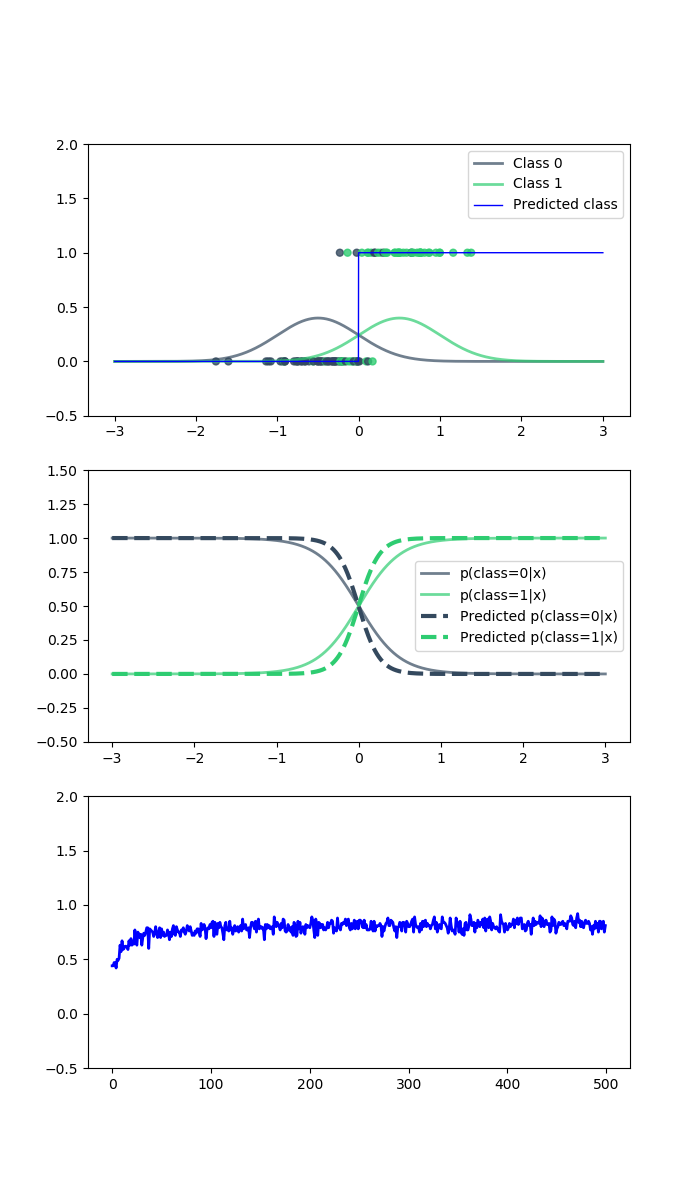

In [5]:
agent = SimpleLogisticAgent(
    n_features=1,
    learning_rate=1.,
    seed=43)

anim = training_loop(
    agent=agent,
    fn_reward=r_accuracy,
    distr_a=Normal(-.5, .5),
    distr_b=Normal(.5, .5),
    n_iter=500,
    n_a=50,
    n_b=50)

Działa. Ponadto widzimy, że nauczona krzywa predykcji rozkładu prawdopodobieństwa akcji jest bardziej stroma, niż krzywa opisująca prawdopodobieństwo warunkowe $p(y\mid x)$. Wiemy, że w granicy powinna być ona praktycznie pionowa, ale postać regresji logistycznej nie pozwala łatwo się tego nauczyć (parametr $w$ musi dążyć do $+\infty$).

Weźmy teraz dwa rozkłady Gaussa z różną wariancją. Zwykła regresja logistyczna nie potrafiła ustawić optymalnie (pod względem accuracy) granicy decyzyjnej. Zobaczmy, czy agent da radę.

<IPython.core.display.Javascript object>


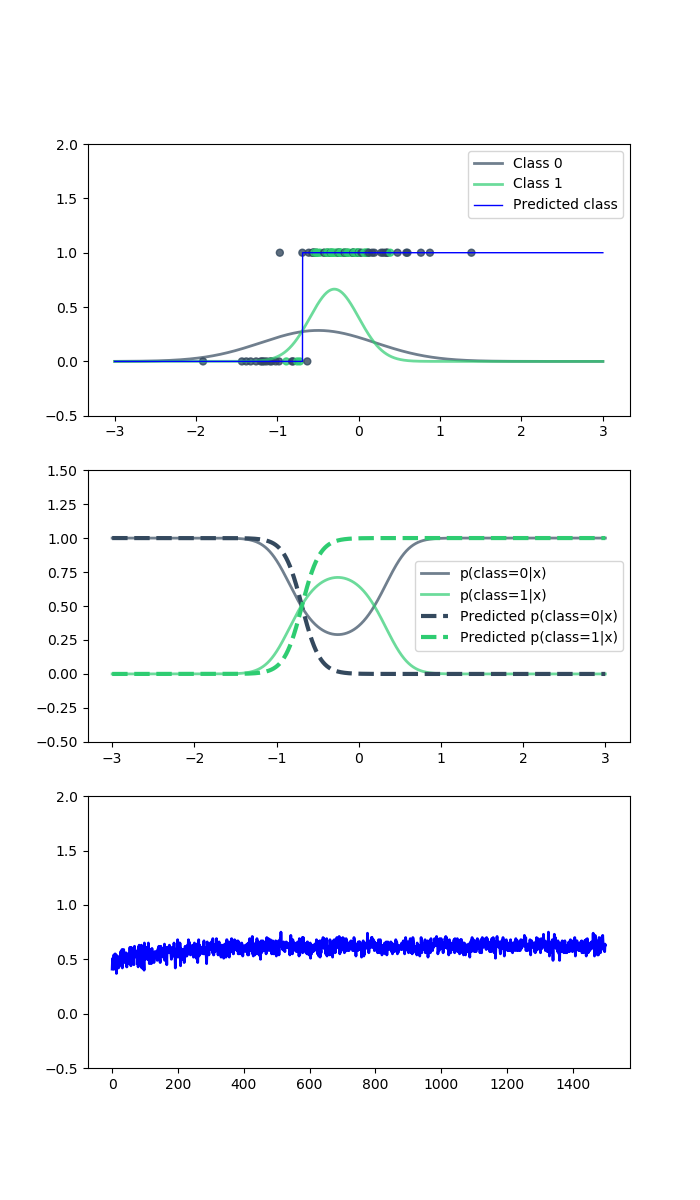

In [6]:
agent = SimpleLogisticAgent(
    n_features=1,
    learning_rate=1.,
    seed=43)

anim = training_loop(
    agent=agent,
    fn_reward=r_accuracy,
    distr_a=Normal(-.5, .7),
    distr_b=Normal(-.3, .3),
    n_iter=1500,
    n_a=50,
    n_b=50)

Jest lepiej - granica decyzyjna oscyluje w dobrym miejscu.

Teraz weźmy dwa rozkłady jednostajne z reparametryzacją kwadratową (aby model mógł się nauczyć dwóch granic decyzyjnych). Zwykła regresja logistyczna nie dawała rady niezależnie od sposobu reparametryzacji.

<IPython.core.display.Javascript object>


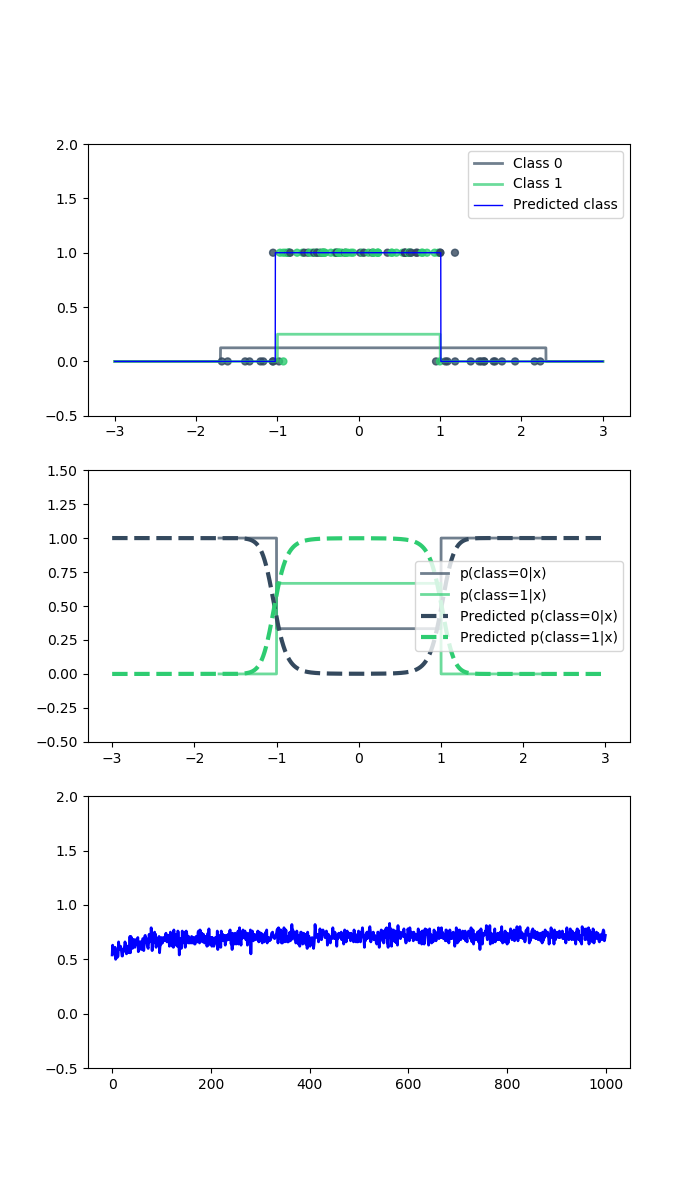

/home/ml/miniconda3/envs/ml2018/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/home/ml/miniconda3/envs/ml2018/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


In [7]:
agent = SimpleLogisticAgent(
    n_features=2,
    learning_rate=1.,
    seed=43)

anim = training_loop(
    agent=agent,
    fn_reward=r_accuracy,
    distr_a=Uniform(.3, 4.),
    distr_b=Uniform(0., 2.),
    featurizer=(lambda x: np.array([x, x**2])),
    n_iter=1000,
    n_a=50,
    n_b=50)

Działa.

Sprawdźmy, czy możemy wziąć inną nagrodę. Np. za przewidzenie poprawnie klasy 0 dajmy jeden punkt, a za przewidzenie poprawnie klasy 1 dwa punkty. Wtedy optymalny threshold to $p(y=1\mid x) = \dfrac{1}{3}$ [dlaczego?]. Czy agent nauczy się takiego thresholdu?

<IPython.core.display.Javascript object>


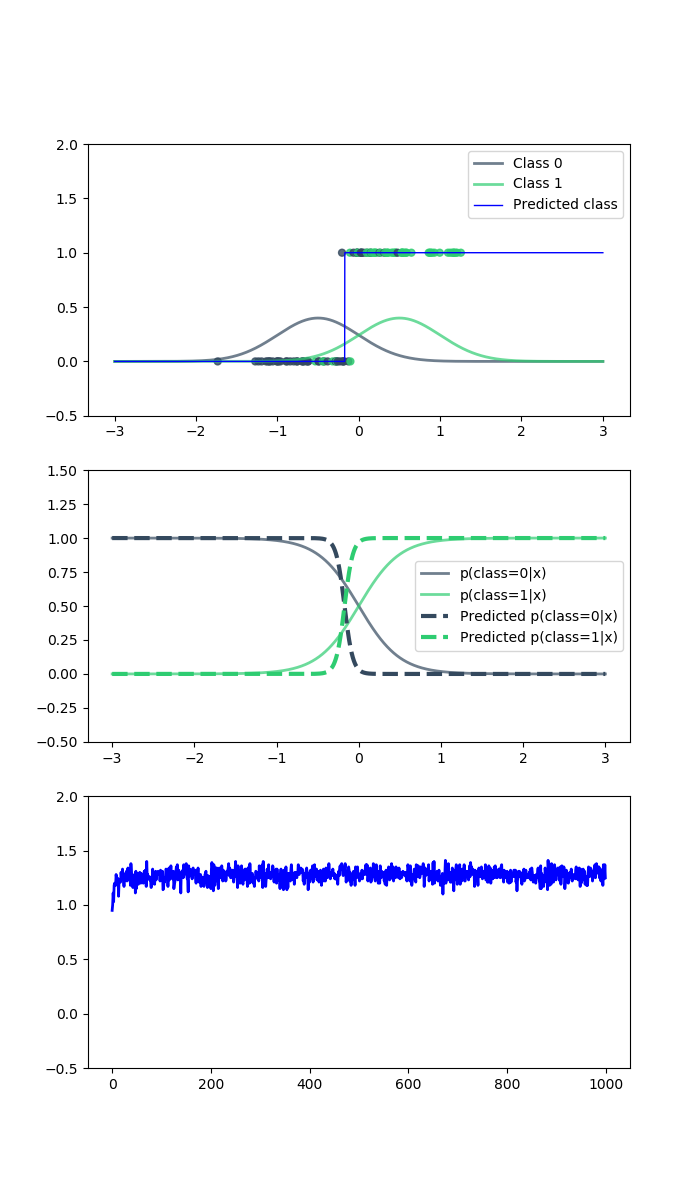

In [8]:
agent = SimpleLogisticAgent(
    n_features=1,
    learning_rate=10.,
    seed=43)

def r_weighted_accuracy(y_true, y_pred):
    result = np.zeros(len(y_pred))
    result[np.logical_and((y_true==y_pred), y_true==0)] = 1.
    result[np.logical_and((y_true==y_pred), y_true==1)] = 2.
    return result

anim = training_loop(
    agent=agent,
    fn_reward=r_weighted_accuracy,
    distr_a=Normal(-.5, .5),
    distr_b=Normal(.5, .5),
    n_iter=1000,
    n_a=50,
    n_b=50)

Nauczył się.

Weźmy teraz znowu dwa rozkłady Gaussa, ale niech mają mniejszą wariancję.

<IPython.core.display.Javascript object>


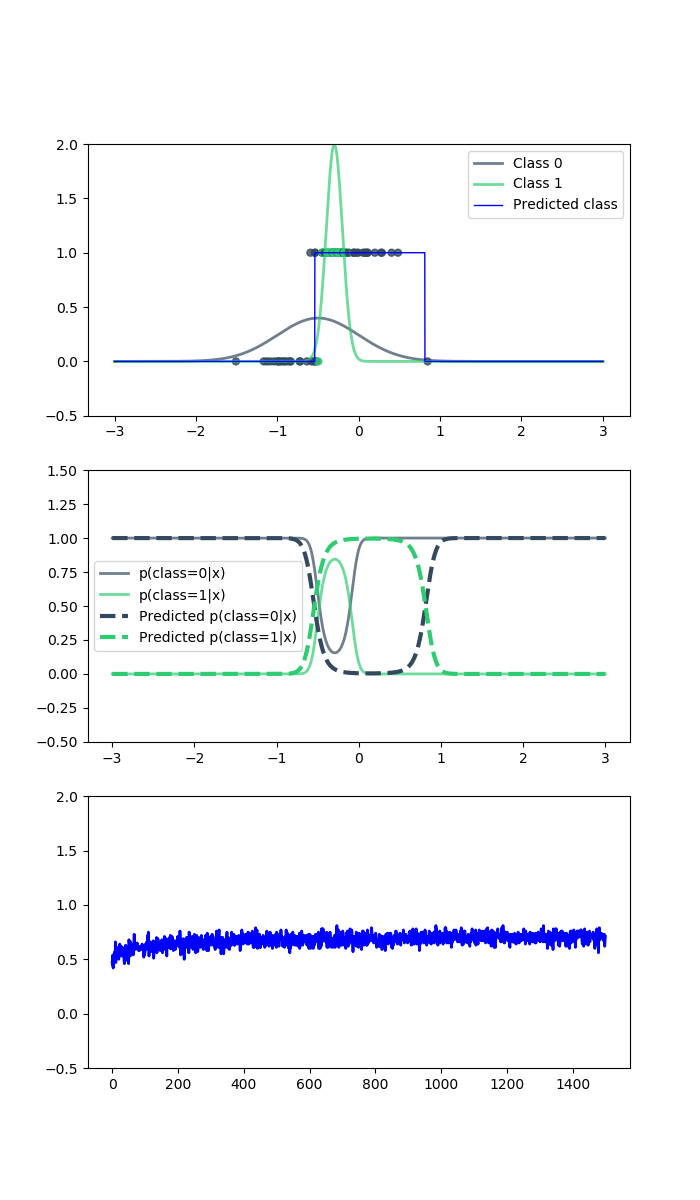

In [9]:
agent = SimpleLogisticAgent(
    n_features=2,
    learning_rate=1.,
    seed=43)

anim = training_loop(
    agent=agent,
    fn_reward=r_accuracy,
    distr_a=Normal(-.5, .5),
    distr_b=Normal(-.3, .1),
    featurizer=(lambda x: np.array([x, x**2])),
    n_iter=1500,
    n_a=50,
    n_b=50)

Agent ma problem z nauczeniem się. Spróbujmy zwiększyć learning rate 43 razy.

<IPython.core.display.Javascript object>


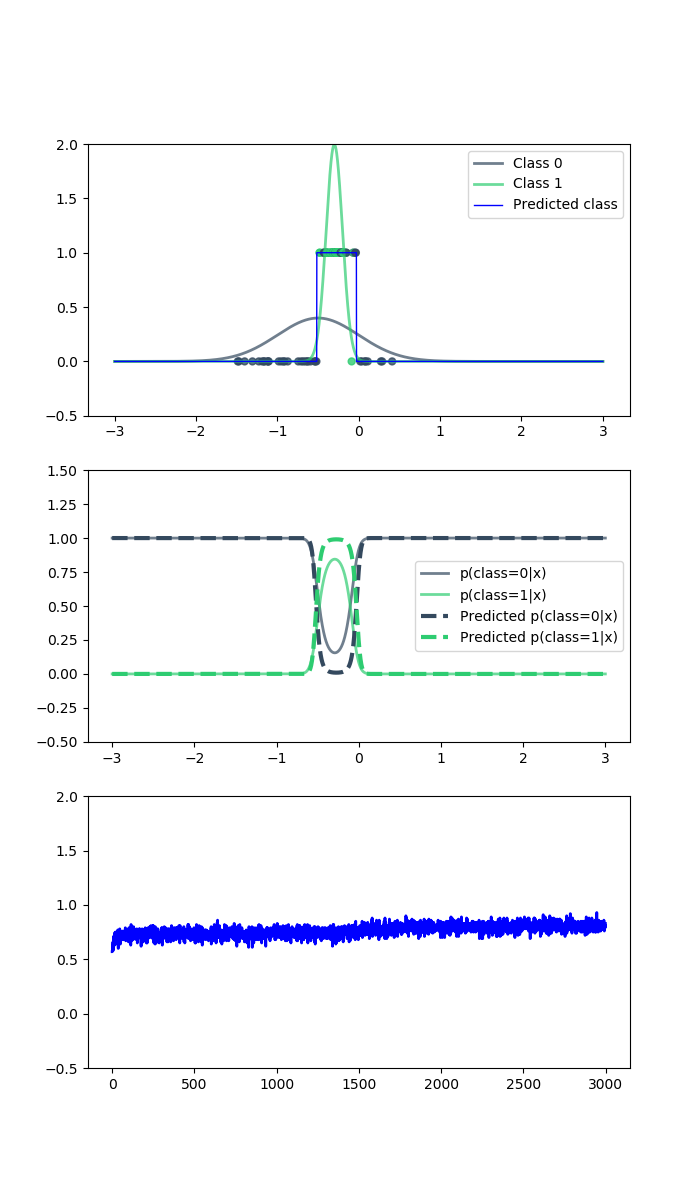

In [10]:
agent = SimpleLogisticAgent(
    n_features=2,
    learning_rate=43.,
    seed=43)

anim = training_loop(
    agent=agent,
    fn_reward=r_accuracy,
    distr_a=Normal(-.5, .5),
    distr_b=Normal(-.3, .1),
    featurizer=(lambda x: np.array([x, x**2])),
    n_iter=3000,
    n_a=50,
    n_b=50)

Tym razem poszło lepiej, choć widzimy już, że uczenie robi się trudniejsze i bardziej niestabilne.

Zobaczmy, czy da się całkiem zepsuć uczenie. Przesuńmy rozkłady jednostajne w prawo tak, aby agent źle się zainicjalizował. Czy uda mu się naprawić?

<IPython.core.display.Javascript object>


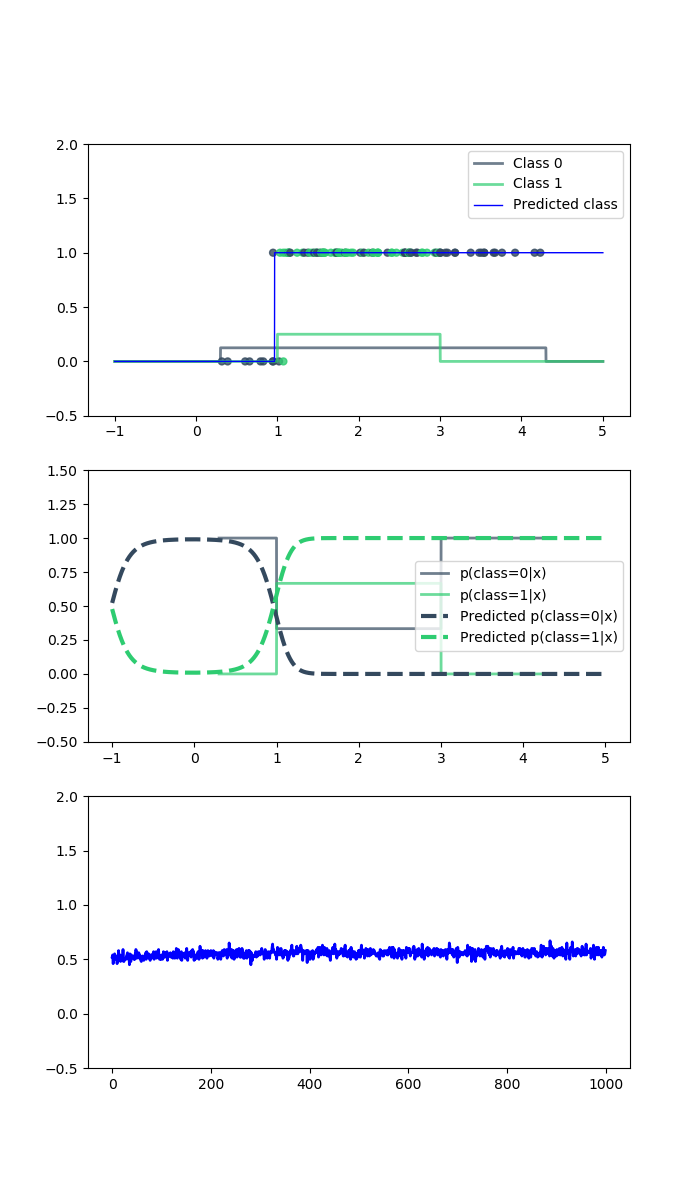

/home/ml/miniconda3/envs/ml2018/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/home/ml/miniconda3/envs/ml2018/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


In [11]:
agent = SimpleLogisticAgent(
    n_features=2,
    learning_rate=1.,
    seed=43)

anim = training_loop(
    agent=agent,
    fn_reward=r_accuracy,
    distr_a=Uniform(2.3, 4.),
    distr_b=Uniform(2., 2.),
    featurizer=(lambda x: np.array([x, x**2])),
    xlim=(-1.,5.),
    n_iter=1000,
    n_a=50,
    n_b=50)

Nie udało się, agent wpadł w lokalne minimum i nie umie z niego wyjść.